# caffe特征可视化

## 导入caffe所需库与图片

Populating the interactive namespace from numpy and matplotlib


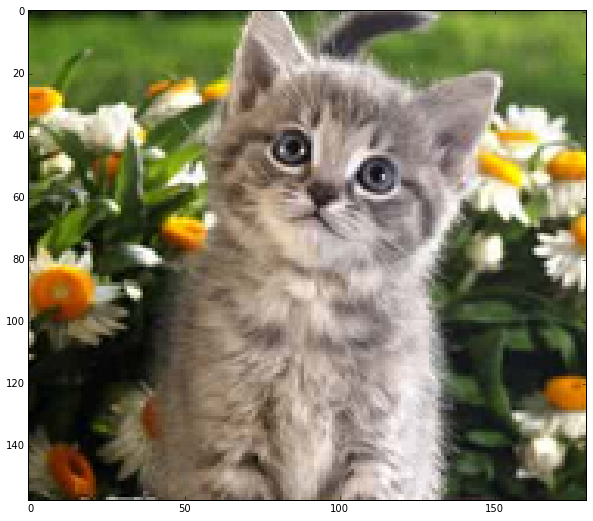

In [1]:
import caffe
%pylab inline
plt.rcParams['figure.figsize'] = (10, 10) 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray'
caffe_root ='/home/alsun/media/faster_rcnn/caffe/'
caffe.set_device(0)  # 如果你有多个GPU，那么选择第一个
caffe.set_mode_gpu()
#net.forward()  # run once before timing to set up memory
model_def = caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
model_weights = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'
net = caffe.Net(model_def,model_weights,   caffe.TEST)  
net.forward()  
mu = np.load(caffe_root + 'models/bvlc_reference_caffenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  #对所有像素值取平均以此获取BGR的均值像素值
#print 'mean-subtracted values:', zip('BGR', mu)
# 对输入数据进行变换
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))  
transformer.set_mean('data', mu)            
transformer.set_raw_scale('data', 255)      
transformer.set_channel_swap('data', (2,1,0))  
net.blobs['data'].reshape(50, 3,227, 227)  
#image = caffe.io.load_image(caffe_root + 'models/bvlc_reference_caffenet/cat.jpg')
image = caffe.io.load_image('/media/alsun/文档/debian/00-classification-file/1.png')
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)
plt.show()

## 输出标签

In [2]:
net.blobs['data'].data[...] = transformed_image
### 执行分类
output = net.forward()  
output_prob = output['prob'][0]  #batch中第一张图像的概率值   
print 'predicted class is:', output_prob.argmax()

predicted class is: 287


In [3]:
labels_file = caffe_root + 'models/bvlc_reference_caffenet/synset_words.txt'
labels = np.loadtxt(labels_file, str, delimiter='\t')
print 'output label:', labels[output_prob.argmax()]

output label: n02127052 lynx, catamount


输出可能性最大的几个标签

In [4]:
top_inds = output_prob.argsort()[::-1][:5]  
print 'probabilities and labels:',zip(output_prob[top_inds], labels[top_inds])#

probabilities and labels: [(0.69968605, 'n02127052 lynx, catamount'), (0.23399161, 'n02123394 Persian cat'), (0.023650285, 'n02123045 tabby, tabby cat'), (0.020101923, 'n02123159 tiger cat'), (0.018657349, 'n02124075 Egyptian cat')]


图片数据随着每层的变化

In [5]:
for layer_name, blob in net.blobs.iteritems():
        print layer_name + '\t' + str(blob.data.shape)

data	(50, 3, 227, 227)
conv1	(50, 96, 55, 55)
pool1	(50, 96, 27, 27)
norm1	(50, 96, 27, 27)
conv2	(50, 256, 27, 27)
pool2	(50, 256, 13, 13)
norm2	(50, 256, 13, 13)
conv3	(50, 384, 13, 13)
conv4	(50, 384, 13, 13)
conv5	(50, 256, 13, 13)
pool5	(50, 256, 6, 6)
fc6	(50, 4096)
fc7	(50, 4096)
fc8	(50, 1000)
prob	(50, 1000)


每层卷积核情况

In [6]:
for layer_name, param in net.params.iteritems():
        print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

conv1	(96, 3, 11, 11) (96,)
conv2	(256, 48, 5, 5) (256,)
conv3	(384, 256, 3, 3) (384,)
conv4	(384, 192, 3, 3) (384,)
conv5	(256, 192, 3, 3) (256,)
fc6	(4096, 9216) (4096,)
fc7	(4096, 4096) (4096,)
fc8	(1000, 4096) (1000,)


卷积核与特征可视化

In [7]:
def vis_square(data):
        """输入一个形如：(n, height, width) or (n, height, width, 3)的数组，并对每一个形如(height,width)的特征进行可视化sqrt(n) by sqrt(n)"""

        # 正则化数据
        data = (data - data.min()) / (data.max() - data.min())

        # 将滤波器的核转变为正方形
        n = int(np.ceil(np.sqrt(data.shape[0])))
        padding = (((0, n ** 2 - data.shape[0]),
                   (0, 1), (0, 1))                 # 在相邻的滤波器之间加入空白 
                   + ((0, 0),) * (data.ndim - 3))  # 不扩展最后一维
        data = np.pad(data, padding, mode='constant', constant_values=1)  # 扩展一个像素(白色)

        # tile the filters into an image
        data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
        data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])

        plt.imshow(data)
        plt.axis('off')
        plt.show()

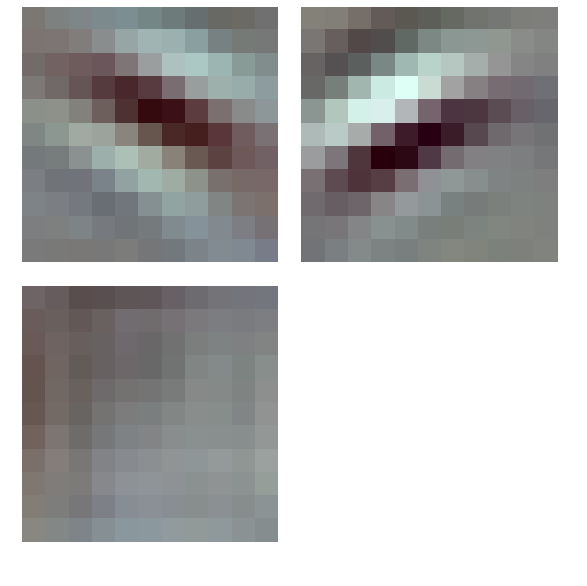

In [8]:
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1)[0:3])
#vis_square(weight.reshape(96*3, 11, 11))

(256, 48, 5, 5)


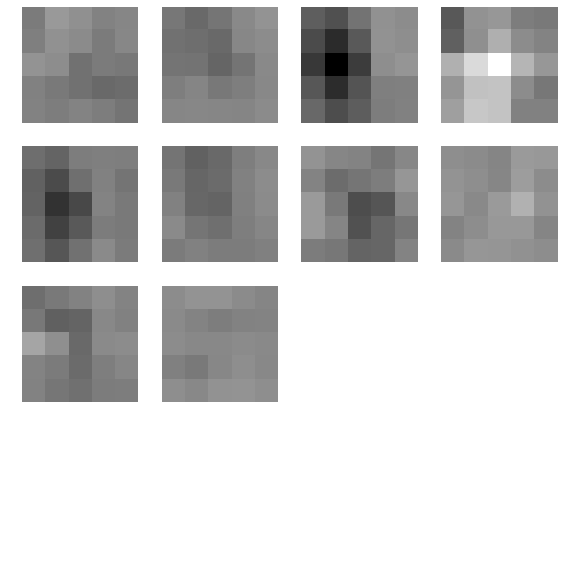

In [9]:
weight = net.params["conv2"][0].data
print weight.shape
vis_square(weight.reshape(256*48, 5, 5)[0:10])

(384, 256, 3, 3)


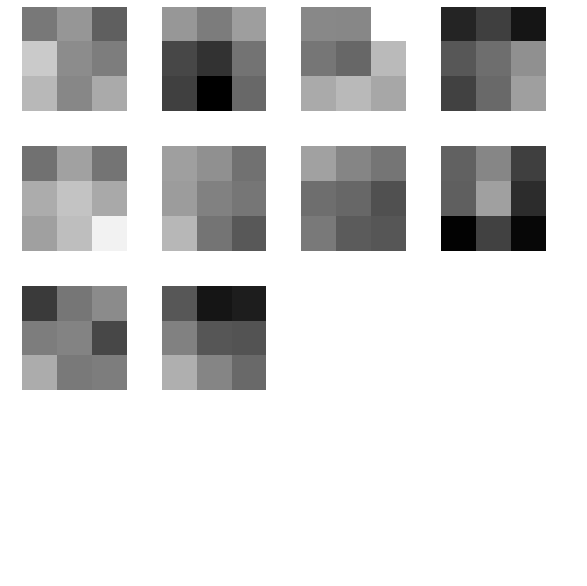

In [10]:
weight = net.params["conv3"][0].data
print weight.shape
vis_square(weight.reshape(256*384, 3,3)[0:10])

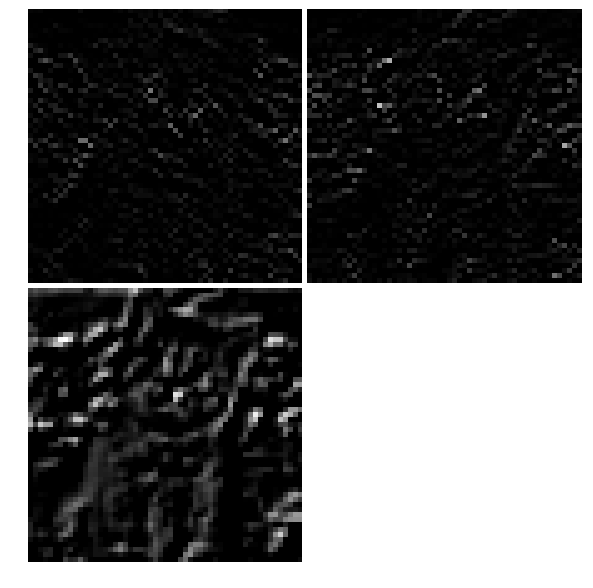

In [11]:
feat = net.blobs['conv1'].data[0, :3]
vis_square(feat)

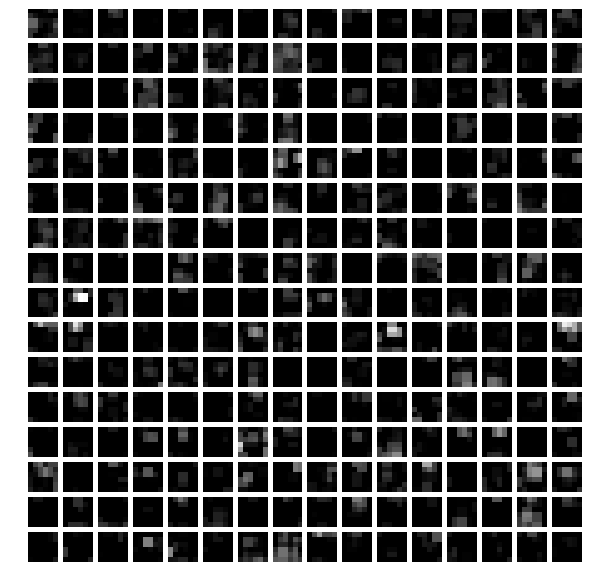

In [12]:
feat = net.blobs['pool5'].data[0]
vis_square(feat)

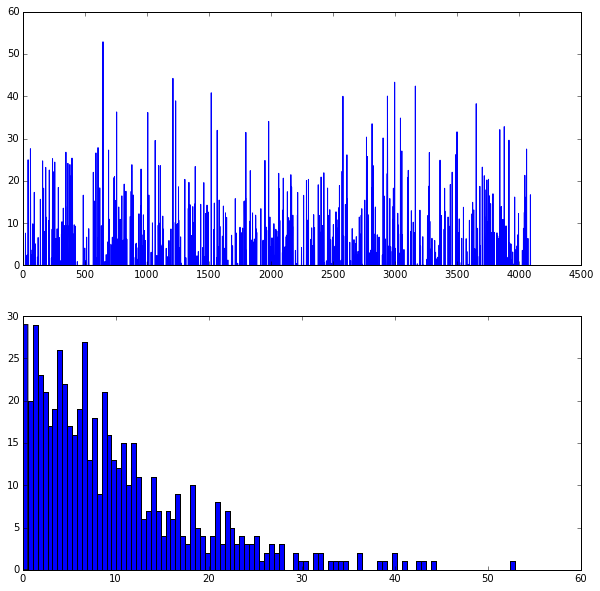

In [13]:
feat = net.blobs['fc6'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)
plt.show()

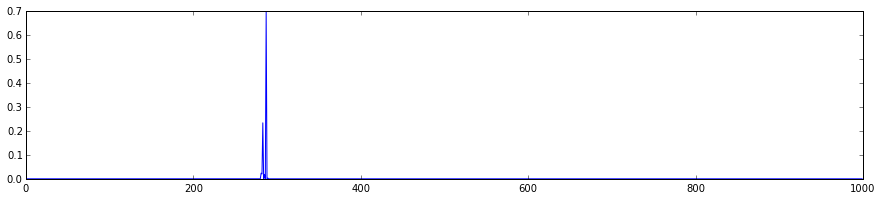

In [14]:
feat = net.blobs['prob'].data[0]
plt.figure(figsize=(15, 3))
plt.plot(feat.flat)
plt.show()